**Read me first:** This notebook is intended to show a full journey of how I build my own reinforcement learning model complete with code, notes, and comments to document my entire story. There are many different versions of my code, but the latest and most up-to-date one is at the very bottom. Accompanying this notebook are two folders named `drift_functions` and `training_data` that store timestamped versions of the models I generated throughout the training process along with the training data that uses one of the models to train a new generation.

# A stochastic pathfinding simulation

We construct a simulation to find a path stochastically and use tested trajectories to construct a policy that determines what the best routes and paths are at each point. We specifically do so under conditions that the path does not cross a certain set of obstacles, which we define as lines.

First, we must define what conditions there are for two line segments to intersect. Take four points in 2D space, $(x_1, y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4)$, and take the lines that connect $(x_1, y_1)$, $(x_2, y_2)$ and $(x_3, y_3)$, $(x_4, y_4)$. Parametrize them by:
$$
\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}x_1 \\ y_1\end{bmatrix} + t\begin{bmatrix}x_2 - x_1 \\ y_2 - y_1\end{bmatrix}, \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}x_3 \\ y_3\end{bmatrix} + t\begin{bmatrix}x_4 - x_3 \\ y_4 - y_3\end{bmatrix}
$$
We want to equate the right hand sides of this equation and set the $t$ variables to be separate and independent. Thus we set the equation:
$$
\begin{bmatrix}x_1 \\ y_1\end{bmatrix} + t_1\begin{bmatrix}x_2 - x_1 \\ y_2 - y_1\end{bmatrix} = \begin{bmatrix}x_3 \\ y_3\end{bmatrix} + t_2\begin{bmatrix}x_4 - x_3 \\ y_4 - y_3\end{bmatrix}
$$
This transforms into a matrix system:
$$
\begin{bmatrix}x_2 - x_1 & -x_4 + x_3 \\ y_2 - y_1 & -y_4 + y_3\end{bmatrix} \begin{bmatrix}t_1 \\ t_2\end{bmatrix} = \begin{bmatrix}x_3 - x_1 \\ y_3 - y_1\end{bmatrix}
$$

In [3]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

In [4]:
def intersect(startpoint_1, endpoint_1, startpoint_2, endpoint_2):
    A = np.array([[endpoint_1[0] - startpoint_1[0], -endpoint_2[0] + startpoint_2[0]],
                  [endpoint_1[1] - startpoint_1[1], -endpoint_2[1] + startpoint_2[1]]])
    b = np.array([startpoint_2[0] - startpoint_1[0], startpoint_2[1] - startpoint_1[1]])
    
    if np.isclose(0, la.det(A)):
        u = endpoint_1 - startpoint_1
        v = startpoint_2 - startpoint_1
        if np.allclose(0, u):
            proj = np.zeros(2)
        else:
            proj = np.dot(u, v) / np.dot(u, u) * u

        if np.allclose(v, proj):
            v_start = startpoint_2 - startpoint_1
            proj1 = np.dot(u, v_start) / np.dot(u, u)
            v_end = endpoint_2 - startpoint_1
            proj2 = np.dot(u, v_end) / np.dot(u, u)
            if max(proj1, proj2) < 0 or min(proj1, proj2) > 1:
                return False
            else:
                return True
        else:
            return False
    else:
        t = la.solve(A, b)
        if np.logical_and((t >= 0), (t <= 1)).all():
            return True
        else:
            return False

[0.54954334 0.20950536] [ 0.22391612 -0.74850156] [-0.15510992 -1.86360972] [ 0.06217223 -1.22435786]


False

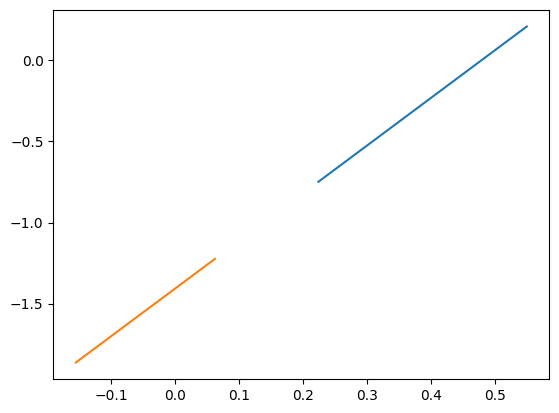

In [538]:
#startpoint_1 = np.random.rand(2)
#endpoint_1 = np.random.rand(2)
#startpoint_2 = np.random.rand(2)
#endpoint_2 = np.random.rand(2)
direction = np.random.rand(2) * 2 - np.ones(2)
startpoint_1 = np.random.rand(2)
endpoint_1 = startpoint_1 + direction
startpoint_2 = startpoint_1 + (np.random.rand() * 5 - 2) * direction
endpoint_2 = startpoint_1 + (np.random.rand() * 5 - 2) * direction

print(startpoint_1, endpoint_1, startpoint_2, endpoint_2)
fig, ax = plt.subplots()

ax.plot(np.array([[startpoint_1[0], startpoint_2[0]], [endpoint_1[0], endpoint_2[0]]]), np.array([[startpoint_1[1], startpoint_2[1]], [endpoint_1[1], endpoint_2[1]]]))

intersect(startpoint_1, endpoint_1, startpoint_2, endpoint_2)

Now it's time to create a function to implement a Brownian motion in an obstacle course. We start by writing a function that can be built up over time.

In [5]:
def brownian_motion_obstacle_course(start_point = np.zeros(2),
                                    timestep = 0.01,
                                    time_limit = 10,
                                    obstacles = [],
                                    exits = [],
                                    x_mesh = np.linspace(-1, 1), y_mesh = np.linspace(-1, 1),
                                    drift = np.zeros((len(np.linspace(-1, 1)), len(np.linspace(-1, 1)), 2))):
    
    success = False
    time_taken = None
    time = 0
    position = start_point
    times = np.zeros(0)
    path = np.zeros((2, 0))
    while time <= time_limit:
        times = np.append(times, time)
        path = np.append(path, np.transpose(np.array([position])), axis=1)
        if success:
            time_taken = time
            break
        
        time += timestep
        while True:
            candidate_position = position + np.random.standard_normal(2) * np.sqrt(timestep)
            collision = False
            for obstacle in obstacles:
                for segment in range(obstacle.shape[1] - 1):
                    if intersect(obstacle[:,segment], obstacle[:,segment + 1], position, candidate_position):
                        collision = True
                        break
            if not collision:
                break
        for exit in exits:
            for segment in range(exit.shape[1] - 1):
                if intersect(exit[:,segment], exit[:,segment + 1], position, candidate_position):
                    success = True
        position = candidate_position
    return path, success, time_taken
    

In this example, I've made a maze as the obstacle. Can the Brownian motion escape the maze? Try running it several times and changing the time limit so the motion will escape. Also try building other shapes for obstacles.

Success! Time: 1498


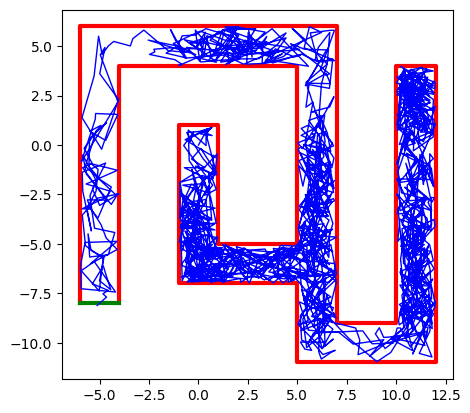

In [980]:
# obstacles = [np.array([[0.9, 0, -1, 0, 0.9], [0.1, 1, 0, -1, -0.1]])]
obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

result = brownian_motion_obstacle_course(start_point = np.zeros(2),
                                       timestep = 1,
                                       time_limit = 2000,
                                       obstacles = obstacles,
                                       exits = exits,
                                       x_mesh = x_mesh, y_mesh = y_mesh)

fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.plot(result[0][0], result[0][1], 'b', linewidth=1)

if result[1]:
    print('Success! Time:', result[2])
else:
    print('Fail')

We can now start working towards training the model by adding a drift based on which direction is most likely to take the path to the exit at each point. First we need a function that will give an interpolation of a function when given points on the grid points on a mesh. We can use bilinear interpolation. That is, how to determine the value at any point within the rectangle given what we know about the value of the function on each of the corners. Suppose $f_{00}, f_{01}, f_{10}, f_{11}$ are the values of $f(0, 0), f(0, 1), f(1, 0), f(1, 1)$ respectively. What is $f(x, y)$ if $0 \leq x \leq 1$ and $0 \leq y \leq 1$? Fixing $y = 0$, the natural choice would be to impose $f(x, 0) = f_{00} + (f_{10} - f_{00}) x$, and similarly for $y = 1$, the choice is $f(x, 1) = f_{01} + (f_{11} - f_{01}) x$. Now varying $y$ continuously, we can choose to linearly vary these coefficients. Doing so gives
$$
f(x, y) = f_{00} + (f_{01} - f_{00}) y + (f_{10} - f_{00} + (f_{11} - f_{01} - f_{10} + f_{00}) y) x = f_{00} + (f_{10} - f_{00}) x + (f_{01} - f_{00}) y + (f_{11} - f_{01} - f_{10} + f_{00}) xy
$$
Here we set that if x or y are out of bounds for the mesh that it falls back to either endpoint.

In [6]:
def bilinear_interpolation(x, y, x_mesh, y_mesh, values):
    if len(x_mesh) != values.shape[0] or len(y_mesh) != values.shape[1]:
        raise ValueError("Dimensions of function do not match mesh values.")
    
    if x <= x_mesh[0]:
        x = x_mesh[0]
    elif x >= x_mesh[-1]:
        x = x_mesh[-1]

    if y <= y_mesh[0]:
        y = y_mesh[0]
    elif y >= y_mesh[-1]:
        y = y_mesh[-1]

    for x_segment in range(len(x_mesh)):
        if x_mesh[x_segment] <= x <= x_mesh[x_segment + 1]:
            break
    
    for y_segment in range(len(y_mesh)):
        if y_mesh[y_segment] <= y <= y_mesh[y_segment + 1]:
            break
            
    ll_corner = values[x_segment, y_segment]
    lh_corner = values[x_segment, y_segment + 1]
    hl_corner = values[x_segment + 1, y_segment]
    hh_corner = values[x_segment + 1, y_segment + 1]

    t_x = (x - x_mesh[x_segment]) / (x_mesh[x_segment + 1] - x_mesh[x_segment])
    t_y = (y - y_mesh[y_segment]) / (y_mesh[y_segment + 1] - y_mesh[y_segment])

    return ll_corner + (hl_corner - ll_corner) * t_x + (lh_corner - ll_corner) * t_y + (hh_corner - hl_corner - lh_corner + ll_corner) * t_x * t_y

Now we'll add the drift terms as needed into the function code by using the bilinear interpolation function we just constructed.

In [1234]:
def brownian_motion_obstacle_course(start_point = np.zeros(2),
                                    timestep = 0.01,
                                    time_limit = 10,
                                    obstacles = [],
                                    exits = [],
                                    x_mesh = np.linspace(-1, 1), y_mesh = np.linspace(-1, 1),
                                    drift = np.zeros((len(np.linspace(-1, 1)), len(np.linspace(-1, 1)), 2))):
    
    success = False
    time_taken = None
    time = 0
    position = start_point
    times = np.zeros(0)
    path = np.zeros((2, 0))
    while time <= time_limit:
        times = np.append(times, time)
        path = np.append(path, np.transpose(np.array([position])), axis=1)
        if success:
            break
        
        time += timestep
        while True:
            force = bilinear_interpolation(position[0], position[1], x_mesh, y_mesh, drift)
            candidate_position = position + np.random.standard_normal(2) * np.sqrt(timestep) + force * timestep
            collision = False
            for obstacle in obstacles:
                for segment in range(obstacle.shape[1] - 1):
                    if intersect(obstacle[:,segment], obstacle[:,segment + 1], position, candidate_position):
                        collision = True
                        break
            if not collision:
                break
        for exit in exits:
            for segment in range(exit.shape[1] - 1):
                if intersect(exit[:,segment], exit[:,segment + 1], position, candidate_position):
                    success = True
                    time_taken = time
        position = candidate_position
    return {'path': path, 'success': success, 'time_taken': time_taken}
    

What we need to do first is run several iterations of this experiment to record for our training data which will be used to influence the model. We'll record a large number of simulations and store it into an array which will be processed.

In [979]:
training_data = [] # Run to reset training data

In [ ]:
obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

N = 100

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.zeros(2),
                                                timestep = 1,
                                                time_limit = 2000,
                                                obstacles = obstacles,
                                                exits = exits)
    
    training_data.append(data_point)

We'll do some analysis of the data we've collected. We've collected 500 runs here. We'll visualize all the trajectories that happened both successful and failed. We'll see how many runs were successful and what the distribution of times is.

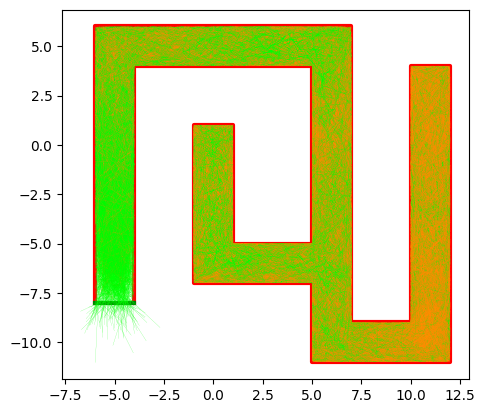

In [1085]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

208


(array([ 8., 17., 24., 38., 17., 27., 26., 21., 13., 17.]),
 array([ 223.,  400.,  577.,  754.,  931., 1108., 1285., 1462., 1639.,
        1816., 1993.]),
 <BarContainer object of 10 artists>)

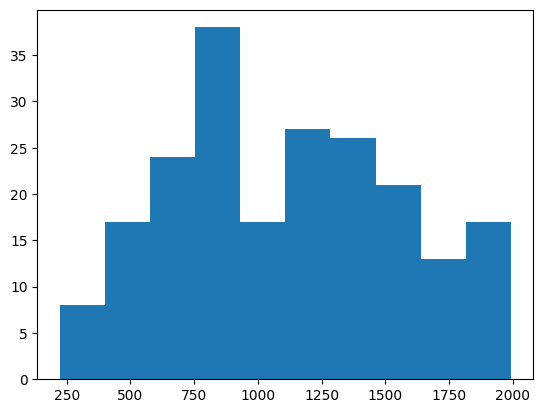

In [1087]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

Based on this result, 208 out of 500 runs are successful, and the time distribution is quite variable. We get a 40% success rate, but that's just what happens with the base model.

It's important to save your data when modelling something like this! That way you will be able to access that data when you continue working on it. Pickle is a tool where you can serialize objects and save them in a file you can access and unpickle later. This code also timestamps your pickle file so you know how up to date it is.

In [ ]:
import pickle
import datetime

filename = 'stochastic_path_simulation_model_training_data_gen_000_{}.pkl'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

stochastic_path_simulation_model_gen_000_20251023_200606.pkl


Now, to access your Pickle file, you can use the following block to retrieve the data:

In [ ]:
import pickle

with open('stochastic_path_simulation_model_training_data_gen_000_20251023_200606.pkl', 'rb') as f:
    training_data = pickle.load(f)
    f.close()

Now it's time to model a drift based on the data we collected. One way to do this is use the mesh to record drift values of successful runs by adding a bias vector to a grid point with weight considerations based on what direction a successful trajectory moved, and use a weight based on the time taken, say inversely proportional.

In [1178]:
x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)
drift_totals = np.zeros((len(x_mesh), len(y_mesh), 2))
drift_weights = np.zeros((len(x_mesh), len(y_mesh)))

In [1142]:
for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken']
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        end = data_point['path'][:, i + 1]
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction * weight

In [1146]:
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

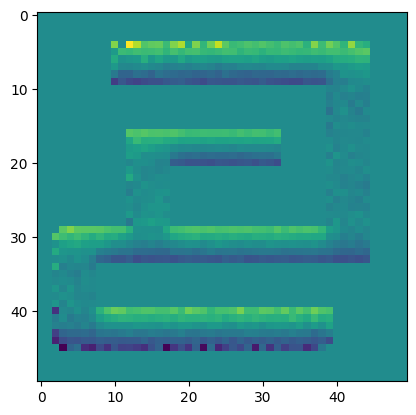

In [1153]:
fig, ax = plt.subplots()
ax.imshow(drift[:, :, 0])

We've successfully created a drift function! Now it's time to redo the simulation with the new drift in place.

Success! Time: 729


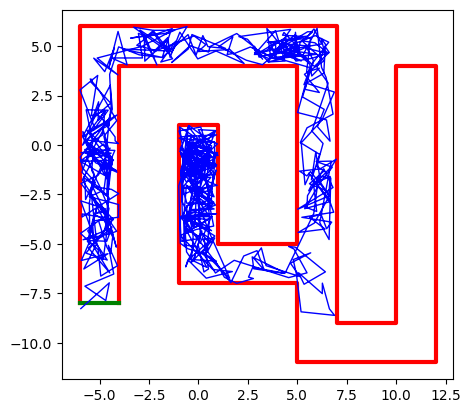

In [1159]:
obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

result = brownian_motion_obstacle_course(start_point = np.zeros(2),
                                       timestep = 1,
                                       time_limit = 2000,
                                       obstacles = obstacles,
                                       exits = exits,
                                       x_mesh = x_mesh, y_mesh = y_mesh,
                                       drift = drift)

fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.plot(result['path'][0], result['path'][1], 'b', linewidth=1)

if result['success']:
    print('Success! Time:', result['time_taken'])
else:
    print('Fail')

How will this simulation do? It might not be a big improvement compared to the base, but with weight's added, it could make a difference. We'll compare the performance of the new model. The last model had a success rate of about 40%. Will this one do better, with better times? We'll do another iteration if it succeeds.

In [1163]:
training_data = [] # Run to reset training data

In [ ]:
obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

N = 400

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.zeros(2),
                                                timestep = 1,
                                                time_limit = 2000,
                                                obstacles = obstacles,
                                                exits = exits,
                                                x_mesh = x_mesh, y_mesh = y_mesh,
                                                drift = drift)
    
    training_data.append(data_point)

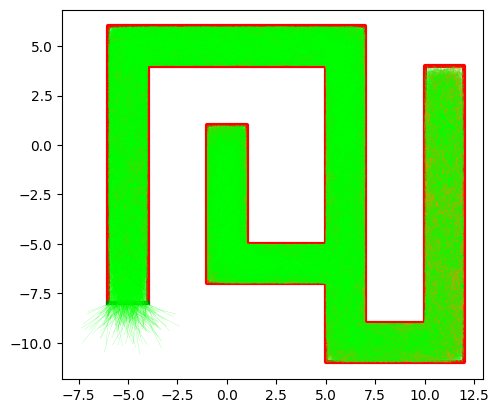

In [1190]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

467


(array([70., 98., 72., 73., 51., 33., 32., 18., 13.,  7.]),
 array([ 176. ,  358.4,  540.8,  723.2,  905.6, 1088. , 1270.4, 1452.8,
        1635.2, 1817.6, 2000. ]),
 <BarContainer object of 10 artists>)

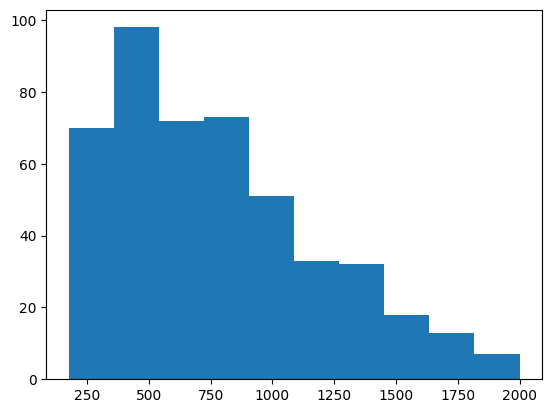

In [1191]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

This time, 467 out of 500 runs (93%) produced a success. A significant improvement from the last model, and times have become more concentrated on the low end. That's clearly an improvement adding the drift function. Congratulations! Now let's save the important data again, including the drift function we obtained.

In [1169]:
import pickle
import datetime

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'stochastic_path_simulation_model_drift_function_gen_001_{}.pkl'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

stochastic_path_simulation_model_drift_function_gen_001_20251023_202339.pkl


In [1174]:
import pickle
import datetime

filename = 'stochastic_path_simulation_model_training_data_gen_001_{}.pkl'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

stochastic_path_simulation_model_training_data_gen_001_20251023_203144.pkl


Shall we make another drift function based on the data we obtained for this generation?

In [1187]:
import pickle

with open('stochastic_path_simulation_model_drift_function_gen_001_20251023_202339.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

In [1192]:
drift_totals = drift_function['totals']
drift_weights = drift_function['weights']

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken']
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        end = data_point['path'][:, i + 1]
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

In [1193]:
import pickle
import datetime

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'stochastic_path_simulation_model_drift_function_gen_002_{}.pkl'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

stochastic_path_simulation_model_drift_function_gen_002_20251023_204237.pkl


Now let's keep iterating. But the thing it our last model produced a 93% success rate, so that's too boring. Shall we do something to raise the difficulty a little bit? Say, the time limit is now 1000.

In [1223]:
import pickle

with open('stochastic_path_simulation_model_drift_function_gen_002_20251023_204237.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

In [1217]:
training_data = [] # Run to reset training data

In [ ]:
obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

N = 500

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.zeros(2),
                                                timestep = 1,
                                                time_limit = 1000,
                                                obstacles = obstacles,
                                                exits = exits,
                                                x_mesh = x_mesh, y_mesh = y_mesh,
                                                drift = drift)
    
    training_data.append(data_point)

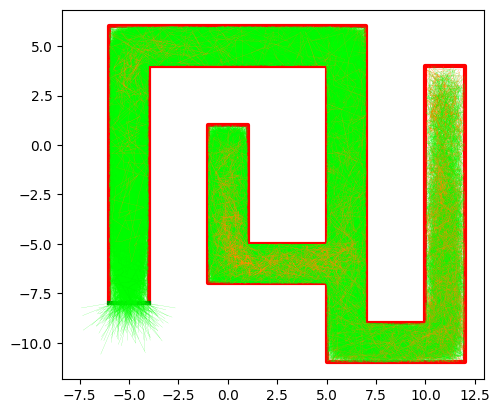

In [1219]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

463


(array([12., 46., 85., 87., 68., 59., 44., 19., 22., 21.]),
 array([100. , 189.4, 278.8, 368.2, 457.6, 547. , 636.4, 725.8, 815.2,
        904.6, 994. ]),
 <BarContainer object of 10 artists>)

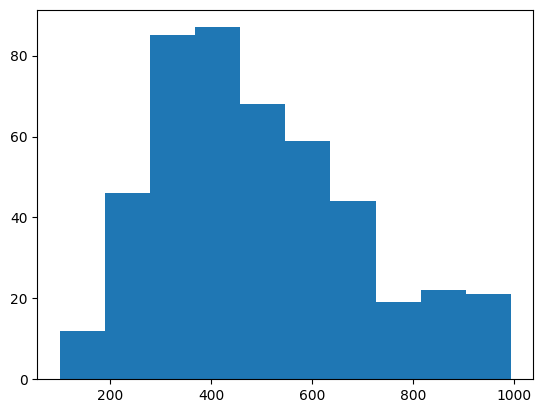

In [1224]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

In [1225]:
drift_totals = drift_function['totals']
drift_weights = drift_function['weights']

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken']
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        end = data_point['path'][:, i + 1]
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

In [1226]:
import pickle
import datetime

filename = 'stochastic_path_simulation_model_training_data_gen_002_{}.pkl'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

stochastic_path_simulation_model_training_data_gen_002_20251023_212058.pkl


In [1227]:
import pickle
import datetime

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'stochastic_path_simulation_model_drift_function_gen_003_{}.pkl'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

stochastic_path_simulation_model_drift_function_gen_003_20251023_212100.pkl


In [ ]:
import pickle

with open('stochastic_path_simulation_model_drift_function_gen_003_20251023_212100.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

drift_totals = drift_function['totals']
drift_weights = drift_function['weights']

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken']
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        end = data_point['path'][:, i + 1]
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

In [ ]:
import numpy as np
import pickle
import datetime

# Load the latest drift function

generation = 16

with open('stochastic_path_simulation_model_drift_function_gen_016_20251023_231830.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

# If too much accumulates, you can divide the drift function by a factor. Comment to disable

drift_function['weights'] = drift_function['weights'] / 5
drift_function['totals'] = drift_function['totals'] / 5

# Set up the experiment

obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

time_limit = 250
timestep = 0.2

# Run the simulation repeatedly and record training data, then save into new file

training_data = []

N = 500

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.zeros(2),
                                                timestep = timestep,
                                                time_limit = time_limit,
                                                obstacles = obstacles,
                                                exits = exits,
                                                x_mesh = x_mesh, y_mesh = y_mesh,
                                                drift = drift)
    
    training_data.append(data_point)

filename = 'stochastic_path_simulation_model_training_data_gen_{:03d}_{}.pkl'.format(generation, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

# Update drift data based on training data for the next generation and save this drift data in a new generation

drift_totals = drift_function['totals']
drift_weights = drift_function['weights']

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken']
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        end = data_point['path'][:, i + 1]
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction / timestep * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'stochastic_path_simulation_model_drift_function_gen_{:03d}_{}.pkl'.format(generation + 1, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

Now we've created a self-contained cell block that does everything we need to do for one iteration. All you need to do is run the block to do the next iteration but change the filename of the Pickle file given at the top for the latest model and the generation number. If you want to change some parameters, like the time limit, you can also change that. Analysis of results can be done below.

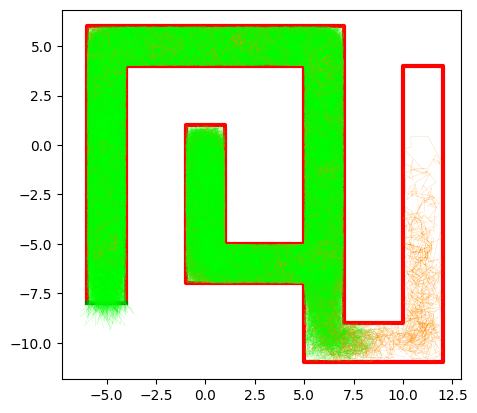

In [1331]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

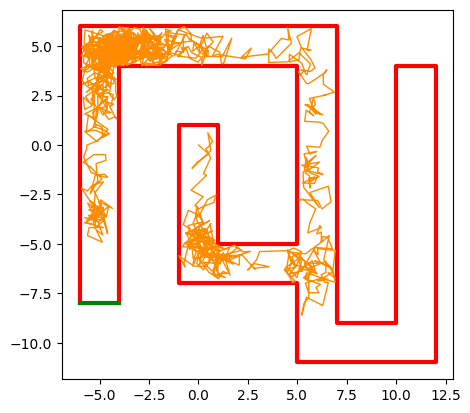

In [1352]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
result = training_data[147]
if result['success'] == True:
    ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=1)
elif result['success'] == False:
    ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=1)

444


(array([ 5., 20., 39., 64., 78., 53., 55., 56., 45., 29.]),
 array([ 62.8 ,  81.52, 100.24, 118.96, 137.68, 156.4 , 175.12, 193.84,
        212.56, 231.28, 250.  ]),
 <BarContainer object of 10 artists>)

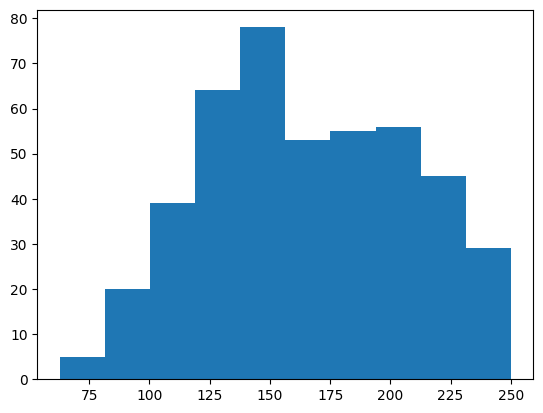

In [1312]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

In [1314]:
excellent_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True) and (x['time_taken'] <= 100), training_data)]
print(excellent_times, len(excellent_times), min(excellent_times))

[92.60000000000078, 62.80000000000035, 84.00000000000065, 97.60000000000085, 84.60000000000066, 81.60000000000062, 97.80000000000085, 96.80000000000084, 92.20000000000077, 71.00000000000047, 87.80000000000071, 89.60000000000073, 99.40000000000087, 94.80000000000081, 88.00000000000071, 96.80000000000084, 88.40000000000072, 74.40000000000052, 87.2000000000007, 98.40000000000086, 77.40000000000056, 96.60000000000083, 78.00000000000057, 90.80000000000075, 98.40000000000086] 25 62.80000000000035


There's a problem: statistics in the drift with the total weight used accumulate over time, and give little space to train new models. That's why we can do something like normalizing the total weight and weighted total vectors by dividing by a factor to give more space for new models. Let's first explore what the total weights look like, to get an idea of what's suitable.

In [1308]:
drift_function['weights']

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0. 

Based on the results, I'd say dividing everything by 10 could be a suitable move before moving onto the next generation.

In [ ]:
drift_function['weights'] = drift_function['weights'] / 10
drift_function['totals'] = drift_function['totals'] / 10

One thing I missed: We can plot an arrow plot of the drift function to visualize how the drift pushes the trajectory towards the exit.

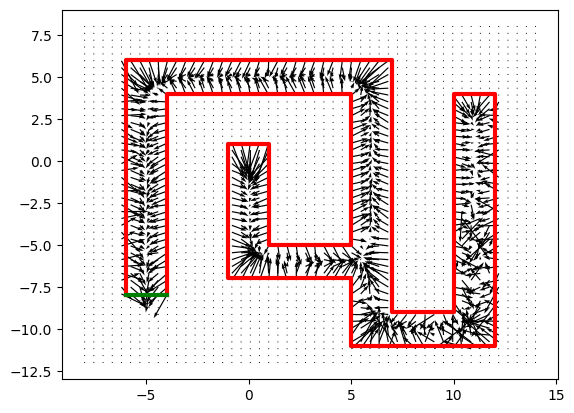

In [1309]:
fig, ax = plt.subplots()

for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.quiver(x_mesh, y_mesh, np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 0], np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 1])


After running the 10th generation of the model, we see some impressive results emerging as a result of the continued training, considering the time limit has now been reduced to 300. We achieved a success rate of nearly 80% on this simulation. According to a histogram generated for that run, the peak now stands at 200. There are also six runs out of 500 which have achieved sub-100 times, with a best time of 77. According to the trajectory plots, paths towards the bad sides of the maze are starting to fade out in green and almost exclusively orange, with even that fading out gradually too as the training model becomes more robust. This is an impressive learning scheme considering how the zeroth generation (base model with pure BM) has produced a measly 40% success rate even with a relaxed time limit of 2000.

At the 15th generation, I've decided I should reduce the time limit to 250 now, and reduce the step size to 0.2. Out of 500 trials, this has produced 444 successes (88.8% success rate) and 25 sub-100s with a minimum time of 62.8. We've gone quite far now in the training. But should we now implement a speed limit? I'm worried that we might face a "speed creep" where drift vectors become too large that it could actually harm the model more than it helps or produce more rejected collisions. Below I'll update the trajectory function to include a new speed limit parameter and reject any steps that exceed the speed limit.

In [1353]:
def brownian_motion_obstacle_course(start_point = np.zeros(2),
                                    timestep = 0.01,
                                    time_limit = 10,
                                    obstacles = [],
                                    exits = [],
                                    x_mesh = np.linspace(-1, 1), y_mesh = np.linspace(-1, 1),
                                    drift = np.zeros((len(np.linspace(-1, 1)), len(np.linspace(-1, 1)), 2)),
                                    speed_limit = np.inf):
    
    success = False
    time_taken = None
    time = 0
    position = start_point
    times = np.zeros(0)
    path = np.zeros((2, 0))
    while time <= time_limit:
        times = np.append(times, time)
        path = np.append(path, np.transpose(np.array([position])), axis=1)
        if success:
            break
        
        time += timestep
        while True:
            force = bilinear_interpolation(position[0], position[1], x_mesh, y_mesh, drift)
            candidate_position = position + np.random.standard_normal(2) * np.sqrt(timestep) + force * timestep
            if np.sqrt(np.dot(position - candidate_position, position - candidate_position)) / timestep > speed_limit:
                speed_limit_exceeded = True
            else:
                speed_limit_exceeded = False
            collision = False
            for obstacle in obstacles:
                for segment in range(obstacle.shape[1] - 1):
                    if intersect(obstacle[:,segment], obstacle[:,segment + 1], position, candidate_position):
                        collision = True
                        break
            if (not collision) and (not speed_limit_exceeded):
                break
        for exit in exits:
            for segment in range(exit.shape[1] - 1):
                if intersect(exit[:,segment], exit[:,segment + 1], position, candidate_position):
                    success = True
                    time_taken = time
        position = candidate_position
    return {'path': path, 'success': success, 'time_taken': time_taken}
    

In [ ]:
import numpy as np
import pickle
import datetime

# Load the latest drift function

generation = 16

with open('stochastic_path_simulation_model_drift_function_gen_016_20251023_235934.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

# If too much accumulates, you can divide the drift function by a factor. Comment to disable

drift_function['weights'] = drift_function['weights'] / 2
drift_function['totals'] = drift_function['totals'] / 2

# Set up the experiment

obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

time_limit = 250
timestep = 0.5

# Run the simulation repeatedly and record training data, then save into new file

training_data = []

N = 500

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.zeros(2),
                                                timestep = timestep,
                                                time_limit = time_limit,
                                                obstacles = obstacles,
                                                exits = exits,
                                                x_mesh = x_mesh, y_mesh = y_mesh,
                                                drift = drift,
                                                speed_limit = 3)
    
    training_data.append(data_point)

filename = 'stochastic_path_simulation_model_training_data_gen_{:03d}_{}.pkl'.format(generation, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

# Update drift data based on training data for the next generation and save this drift data in a new generation

drift_totals = drift_function['totals']
drift_weights = drift_function['weights']

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken']
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        end = data_point['path'][:, i + 1]
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction / timestep * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'stochastic_path_simulation_model_drift_function_gen_{:03d}_{}.pkl'.format(generation + 1, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

Analysis:

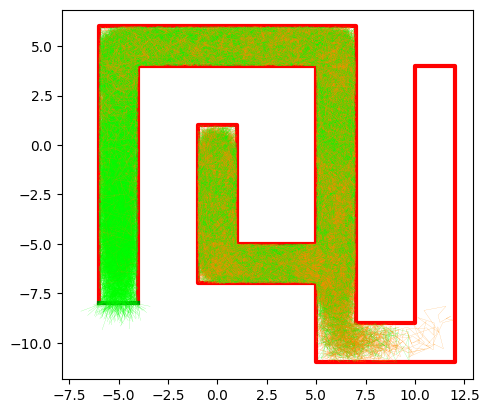

In [1377]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

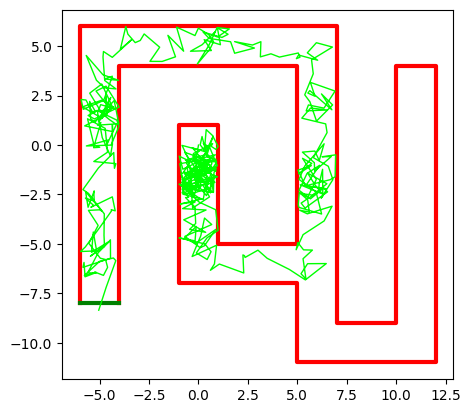

In [1379]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
result = training_data[0]
if result['success'] == True:
    ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=1)
elif result['success'] == False:
    ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=1)

284


(array([ 7.,  9., 19., 31., 35., 32., 39., 33., 38., 41.]),
 array([109.5, 123.6, 137.7, 151.8, 165.9, 180. , 194.1, 208.2, 222.3,
        236.4, 250.5]),
 <BarContainer object of 10 artists>)

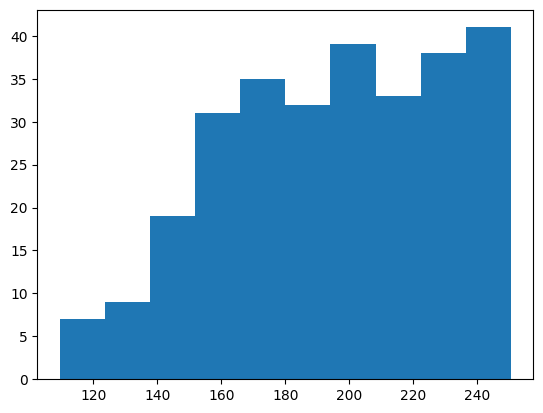

In [1380]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

In [1381]:
excellent_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True) and (x['time_taken'] <= 100), training_data)]
print(excellent_times, len(excellent_times), min(excellent_times))

ValueError: min() iterable argument is empty

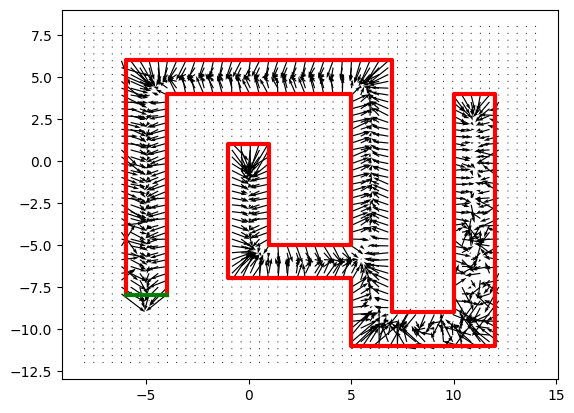

In [1382]:
fig, ax = plt.subplots()

for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.quiver(x_mesh, y_mesh, np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 0], np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 1])


I observe that adding a speed limit has actually produced a lot more failures because some of the paths that once worked well are less likely to succeed. I believe this is just a setback that can be recovered from. If we relax some conditions or roll back to some model that worked well, it could slowly recover. I decide I should roll it back to the 14th generation. Even then, there's still a high failure rate, so I'll increase the time limit temporarily to 600, and hopefully there should be more successes to recover. But that somehow produced a 100% success rate, so I took the time limit too high. Then I'll continue training the next generation. The speed limit should produce something useful.

Upon reducing the step size and keeping the speed limit the same, the model seems to produce more failures. Why? The large step sizes that were possible with large timesteps are harder to achieve. But still, slowly the model should improve the drift vectors to be better guiding towards the exit.

One solution to remedy this is to use rolling velocity over multiple steps instead of individual step sizes, say over 5 steps, or a period of 1 time unit. That way, individual large steps that are likely due to diffusion won't be denied due to the speed limit restriction, but the speed limit can still be enforced by looking at speeds over small time steps. We update the function again.

In [7]:
def brownian_motion_obstacle_course(start_point = np.zeros(2),
                                    timestep = 0.01,
                                    time_limit = 10,
                                    obstacles = [],
                                    exits = [],
                                    x_mesh = np.linspace(-1, 1), y_mesh = np.linspace(-1, 1),
                                    drift = np.zeros((len(np.linspace(-1, 1)), len(np.linspace(-1, 1)), 2)),
                                    speed_limit = np.inf,
                                    rolling_speed_period = 1):
    
    success = False
    time_taken = None
    time = 0
    position = start_point
    times = np.zeros(0)
    path = np.zeros((2, 0))
    while time <= time_limit:
        times = np.append(times, time)
        path = np.append(path, np.transpose(np.array([position])), axis=1)
        if success:
            break
        
        time += timestep
        while True:
            force = bilinear_interpolation(position[0], position[1], x_mesh, y_mesh, drift)
            candidate_position = position + np.random.standard_normal(2) * np.sqrt(timestep) + force * timestep
            if path.shape[1] < rolling_speed_period:
                old_position = path[:, 0]
                steps = path.shape[1]
            else:
                old_position = path[:, path.shape[1] - rolling_speed_period]
                steps = rolling_speed_period
            if np.sqrt(np.dot(candidate_position - old_position, candidate_position - old_position)) / (timestep * steps) > speed_limit:
                speed_limit_exceeded = True
            else:
                speed_limit_exceeded = False
            collision = False
            for obstacle in obstacles:
                for segment in range(obstacle.shape[1] - 1):
                    if intersect(obstacle[:,segment], obstacle[:,segment + 1], position, candidate_position):
                        collision = True
                        break
            if (not collision) and (not speed_limit_exceeded):
                break
        for exit in exits:
            for segment in range(exit.shape[1] - 1):
                if intersect(exit[:,segment], exit[:,segment + 1], position, candidate_position):
                    success = True
                    time_taken = time
        position = candidate_position
    return {'path': path, 'success': success, 'time_taken': time_taken}
    

In [ ]:
import numpy as np
import pickle
import datetime

# Load the latest drift function

generation = 40

with open('drift_functions/gen_040_20251024_095852.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

# If too much accumulates, you can divide the drift function by a factor. Comment to disable

drift_function['weights'] = drift_function['weights'] / 2
drift_function['totals'] = drift_function['totals'] / 2

drift = drift_function['drift_value']

# Set up the experiment

obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

time_limit = 70
timestep = 0.2

# Run the simulation repeatedly and record training data, then save into new file

training_data = []

N = 500

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.zeros(2),
                                                timestep = timestep,
                                                time_limit = time_limit,
                                                obstacles = obstacles,
                                                exits = exits,
                                                x_mesh = x_mesh, y_mesh = y_mesh,
                                                drift = drift,
                                                speed_limit = 3,
                                                rolling_speed_period = 10)
    
    training_data.append(data_point)

filename = 'training_data/gen_{:03d}_{}.pkl'.format(generation, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

# Update drift data based on training data for the next generation and save this drift data in a new generation

drift_totals = drift_function['totals']
drift_weights = drift_function['weights']

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken']
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        end = data_point['path'][:, i + 1]
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction / timestep * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'drift_functions/gen_{:03d}_{}.pkl'.format(generation + 1, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

Analysis:

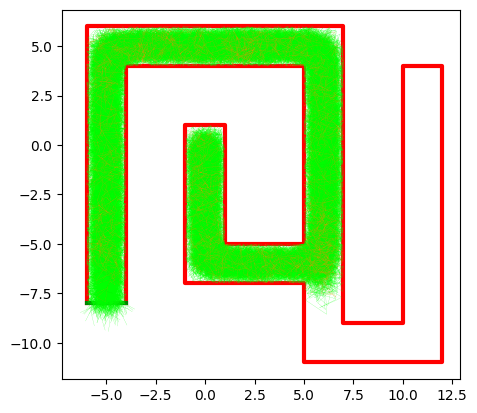

In [135]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

In [136]:
times = [(data_point['time_taken'] if data_point['time_taken'] != None else np.inf) for data_point in training_data]

np.argmin(times)

26

34.59999999999995


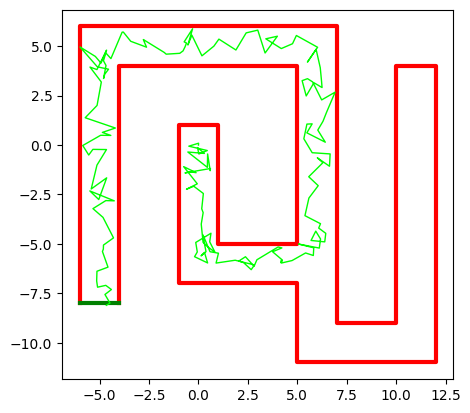

In [137]:
trial_number = 26

fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
result = training_data[trial_number]
if result['success'] == True:
    ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=1)
elif result['success'] == False:
    ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=1)

print(result['time_taken'])

472


(array([ 8., 13., 45., 58., 77., 80., 67., 48., 46., 30.]),
 array([34.6 , 38.12, 41.64, 45.16, 48.68, 52.2 , 55.72, 59.24, 62.76,
        66.28, 69.8 ]),
 <BarContainer object of 10 artists>)

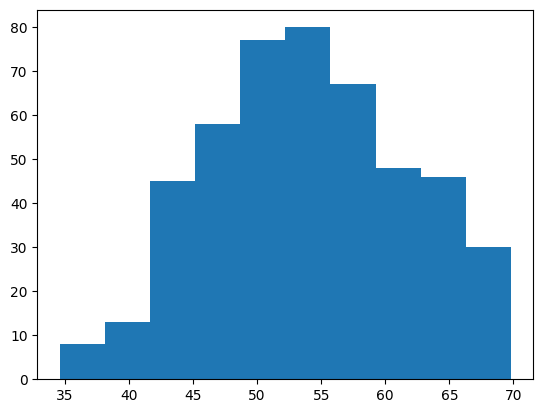

In [138]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

In [139]:
excellent_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True) and (x['time_taken'] <= 40), training_data)]
print(len(excellent_times), min(excellent_times))

14 34.59999999999995


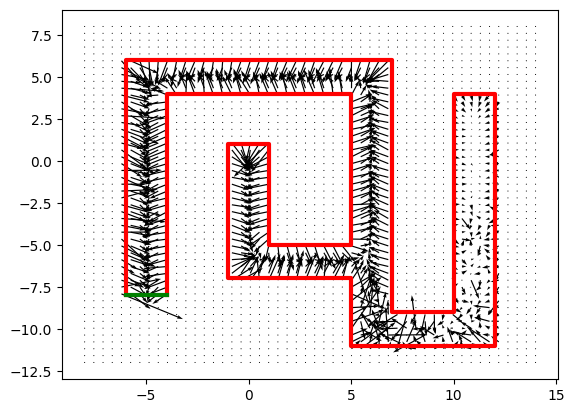

In [140]:
fig, ax = plt.subplots()

for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.quiver(x_mesh, y_mesh, np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 0], np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 1])


Much better now with the use of rolling speed checks instead of single-step checks. There's more freedom without the need to enforce every single step, but speed is still limited overall.

Another point: I've decided from now on that the renormalization process shall involve dividing all weights by a factor of 2 before the next generation starts so the degradation of old models is appropriate. This way you're basing your actions mostly on the most recent models and not dwelling on the past.

But let's add one more thing: penalizing collisions. We eventually want to get the trajectory to avoid collisions with walls, which is by not only rejecting a collision that tries to happen, but penalizing it each time one of these happens. We shall now start counting collisions and applying a division penalty to the weights. Let's update the function once more, such that the weight as previously calculated gets divided by $1/(1 + 0.02 \cdot \text{collisions})$, which I believe will be an appropriate deterrent based on the relative variability of this statistic. I predict that this will align drift vectors even faster towards the exit.

In [142]:
def brownian_motion_obstacle_course(start_point = np.zeros(2),
                                    timestep = 0.01,
                                    time_limit = 10,
                                    obstacles = [],
                                    exits = [],
                                    x_mesh = np.linspace(-1, 1), y_mesh = np.linspace(-1, 1),
                                    drift = np.zeros((len(np.linspace(-1, 1)), len(np.linspace(-1, 1)), 2)),
                                    speed_limit = np.inf,
                                    rolling_speed_period = 1):
    
    success = False
    time_taken = None
    time = 0
    position = start_point
    times = np.zeros(0)
    path = np.zeros((2, 0))
    collisions = 0
    while time <= time_limit:
        times = np.append(times, time)
        path = np.append(path, np.transpose(np.array([position])), axis=1)
        if success:
            break
        
        time += timestep
        while True:
            force = bilinear_interpolation(position[0], position[1], x_mesh, y_mesh, drift)
            candidate_position = position + np.random.standard_normal(2) * np.sqrt(timestep) + force * timestep
            if path.shape[1] < rolling_speed_period:
                old_position = path[:, 0]
                steps = path.shape[1]
            else:
                old_position = path[:, path.shape[1] - rolling_speed_period]
                steps = rolling_speed_period
            if np.sqrt(np.dot(candidate_position - old_position, candidate_position - old_position)) / (timestep * steps) > speed_limit:
                speed_limit_exceeded = True
            else:
                speed_limit_exceeded = False
            collision = False
            for obstacle in obstacles:
                for segment in range(obstacle.shape[1] - 1):
                    if intersect(obstacle[:,segment], obstacle[:,segment + 1], position, candidate_position):
                        collision = True
                        collisions += 1
                        break
            if (not collision) and (not speed_limit_exceeded):
                break
        for exit in exits:
            for segment in range(exit.shape[1] - 1):
                if intersect(exit[:,segment], exit[:,segment + 1], position, candidate_position):
                    success = True
                    time_taken = time
        position = candidate_position
    return {'path': path, 'success': success, 'time_taken': time_taken, 'collisions': collisions}
    

In [ ]:
import numpy as np
import pickle
import datetime

# Load the latest drift function

generation = 70

with open('drift_functions/gen_070_20251025_152813.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

# If too much accumulates, you can divide the drift function by a factor. Comment to disable

drift_function['weights'] = drift_function['weights'] / 2
drift_function['totals'] = drift_function['totals'] / 2

drift = drift_function['drift_value']

# Set up the experiment

obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

time_limit = 50
timestep = 0.1

# Run the simulation repeatedly and record training data, then save into new file

training_data = []

N = 500

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.array([0, 0]),
                                                timestep = timestep,
                                                time_limit = time_limit,
                                                obstacles = obstacles,
                                                exits = exits,
                                                x_mesh = x_mesh, y_mesh = y_mesh,
                                                drift = drift,
                                                speed_limit = 3,
                                                rolling_speed_period = 20)
    
    training_data.append(data_point)

filename = 'training_data/gen_{:03d}_{}.pkl'.format(generation, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

# Update drift data based on training data for the next generation and save this drift data in a new generation

running_period = 10

drift_totals = drift_function['totals']
drift_weights = drift_function['weights']

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken'] / (1 + 0.1 * data_point['collisions'])
    
    for i in range(data_point['path'].shape[1]):
        start = data_point['path'][:, i]
        if i + running_period < data_point['path'].shape[1]:
            end = data_point['path'][:, i + running_period]
        else:
            end = data_point['path'][:, -1]
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction / (timestep * running_period) * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'drift_functions/gen_{:03d}_{}.pkl'.format(generation + 1, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

Analysis:

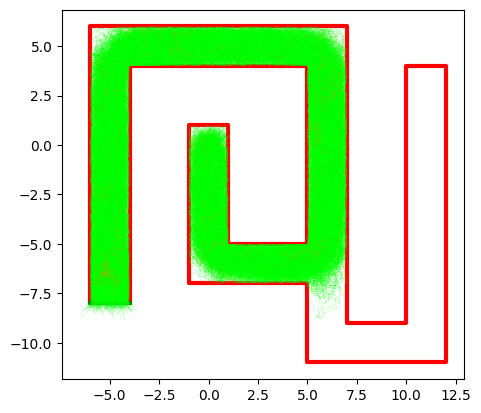

In [400]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

In [401]:
times = [(data_point['time_taken'] if data_point['time_taken'] != None else np.inf) for data_point in training_data]

np.argmin(times)

315

24.800000000000082 10


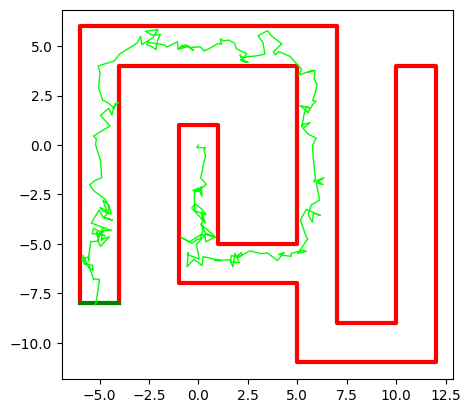

In [402]:
trial_number = 315

fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
result = training_data[trial_number]
if result['success'] == True:
    ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=1)
elif result['success'] == False:
    ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=1)

print(result['time_taken'], result['collisions'])

492


(array([  7.,  32.,  60.,  89., 105.,  80.,  53.,  32.,  19.,  15.]),
 array([24.8, 27.3, 29.8, 32.3, 34.8, 37.3, 39.8, 42.3, 44.8, 47.3, 49.8]),
 <BarContainer object of 10 artists>)

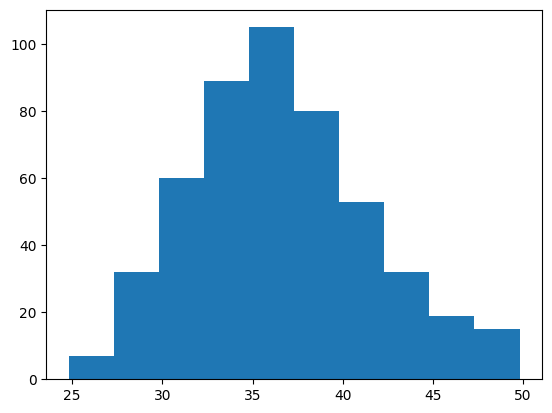

In [403]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

In [404]:
excellent_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True) and (x['time_taken'] <= 50), training_data)]
print(len(excellent_times), min(excellent_times))

492 24.800000000000082


(array([ 14.,  41., 110., 109.,  98.,  70.,  35.,  18.,   3.,   2.]),
 array([ 8. , 12.9, 17.8, 22.7, 27.6, 32.5, 37.4, 42.3, 47.2, 52.1, 57. ]),
 <BarContainer object of 10 artists>)

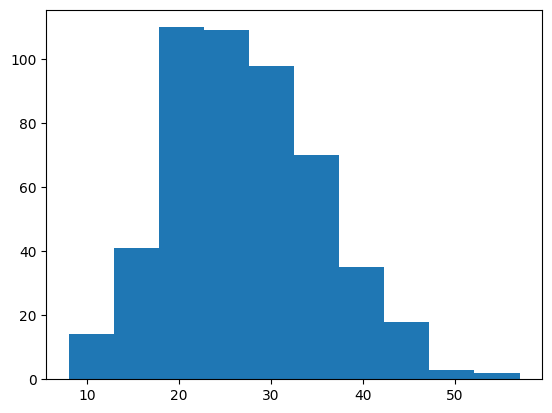

In [405]:
collisions = [data_point['collisions'] for data_point in training_data]
plt.hist(collisions)

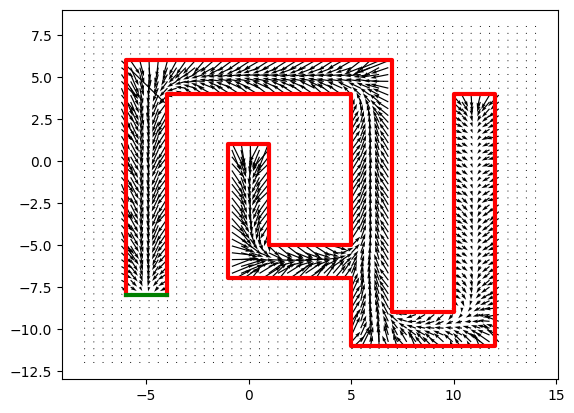

In [396]:
fig, ax = plt.subplots()

for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.quiver(x_mesh, y_mesh, np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 0], np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 1])


After running generation 50, the model with the drift function has now produced very fast times centered at 40, as the time limit is now at a low 50, with a low among runs achieving a time of 26.6. Also, adding a collisions parameter seems to help as well as we've gone from seeing an average of about 10 to now about 7. The drift vectors are slowly pointing towards the right direction. Almost all path are now generally heading towards the right way, with the few that fail just because they can't reach it in time. The "golden path" is becoming staighter as there are even fewer meanders. In this maze, I've measured the distance to the exit to be about 47, so based on the speed limit of 3 which I've imposed earlier, the minimum time it should stabilize to is about 16. To make the model update better faster with more representative data, the drifts are also based on running average directions instead of individual steps, the running can be adjusted as needed. As it turns out, based on the Quiver plot, the force field shifts much quicker with this new weighting scheme.

Another thing that's come to mind is, we should do something to train the part of the maze that has not been explored. That is the bad dead-end path, which becomes unexplored because trajectories, as training progresses, increasingly never touches that part. That's why there's no force field on it that guides the path towards the goal. But once we set the starting point to the other end, we see a force field build up.

Now, there's one more thing we shall try. While the model is producing successful runs, the problem is the paths are too jagged because there's still too much noise. We shall add a diffusion parameter, something we can change to control and reduce the noise as the drift gets better. Initially a large noise was good because it allowed for better exploration, but that stage is mostly done, so we can reduce the diffusion. All we need to do is add a new parameter to our function and modify the function as needed by multiplying each step size by that diffusion parameter.

In this section I've made a self-contained section that should run well by itself from the given code cells below. In other words, you should be able to run starting from the next cell below.

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pickle
import datetime

In [2]:
def intersect(startpoint_1, endpoint_1, startpoint_2, endpoint_2):
    A = np.array([[endpoint_1[0] - startpoint_1[0], -endpoint_2[0] + startpoint_2[0]],
                  [endpoint_1[1] - startpoint_1[1], -endpoint_2[1] + startpoint_2[1]]])
    b = np.array([startpoint_2[0] - startpoint_1[0], startpoint_2[1] - startpoint_1[1]])
    
    if np.isclose(0, la.det(A)):
        u = endpoint_1 - startpoint_1
        v = startpoint_2 - startpoint_1
        if np.allclose(0, u):
            proj = np.zeros(2)
        else:
            proj = np.dot(u, v) / np.dot(u, u) * u

        if np.allclose(v, proj):
            v_start = startpoint_2 - startpoint_1
            proj1 = np.dot(u, v_start) / np.dot(u, u)
            v_end = endpoint_2 - startpoint_1
            proj2 = np.dot(u, v_end) / np.dot(u, u)
            if max(proj1, proj2) < 0 or min(proj1, proj2) > 1:
                return False
            else:
                return True
        else:
            return False
    else:
        t = la.solve(A, b)
        if np.logical_and((t >= 0), (t <= 1)).all():
            return True
        else:
            return False

In [3]:
def bilinear_interpolation(x, y, x_mesh, y_mesh, values):
    if len(x_mesh) != values.shape[0] or len(y_mesh) != values.shape[1]:
        raise ValueError("Dimensions of function do not match mesh values.")
    
    if x <= x_mesh[0]:
        x = x_mesh[0]
    elif x >= x_mesh[-1]:
        x = x_mesh[-1]

    if y <= y_mesh[0]:
        y = y_mesh[0]
    elif y >= y_mesh[-1]:
        y = y_mesh[-1]

    for x_segment in range(len(x_mesh)):
        if x_mesh[x_segment] <= x <= x_mesh[x_segment + 1]:
            break
    
    for y_segment in range(len(y_mesh)):
        if y_mesh[y_segment] <= y <= y_mesh[y_segment + 1]:
            break
            
    ll_corner = values[x_segment, y_segment]
    lh_corner = values[x_segment, y_segment + 1]
    hl_corner = values[x_segment + 1, y_segment]
    hh_corner = values[x_segment + 1, y_segment + 1]

    t_x = (x - x_mesh[x_segment]) / (x_mesh[x_segment + 1] - x_mesh[x_segment])
    t_y = (y - y_mesh[y_segment]) / (y_mesh[y_segment + 1] - y_mesh[y_segment])

    return ll_corner + (hl_corner - ll_corner) * t_x + (lh_corner - ll_corner) * t_y + (hh_corner - hl_corner - lh_corner + ll_corner) * t_x * t_y

In [4]:
def brownian_motion_obstacle_course(start_point = np.zeros(2),
                                    timestep = 0.01,
                                    time_limit = 10,
                                    obstacles = [],
                                    exits = [],
                                    x_mesh = np.linspace(-1, 1), y_mesh = np.linspace(-1, 1),
                                    drift = np.zeros((len(np.linspace(-1, 1)), len(np.linspace(-1, 1)), 2)),
                                    diffusion = 1,
                                    speed_limit = np.inf,
                                    rolling_speed_period = 1):
    
    success = False
    time_taken = None
    time = 0
    position = start_point
    times = np.zeros(0)
    path = np.zeros((2, 0))
    collisions = 0
    while time <= time_limit:
        times = np.append(times, time)
        path = np.append(path, np.transpose(np.array([position])), axis=1)
        if success:
            break
        
        time += timestep
        while True:
            force = bilinear_interpolation(position[0], position[1], x_mesh, y_mesh, drift)
            candidate_position = position + np.random.standard_normal(2) * diffusion * np.sqrt(timestep) + force * timestep
            if path.shape[1] < rolling_speed_period:
                old_position = path[:, 0]
                steps = path.shape[1]
            else:
                old_position = path[:, path.shape[1] - rolling_speed_period]
                steps = rolling_speed_period
            if np.sqrt(np.dot(candidate_position - old_position, candidate_position - old_position)) / (timestep * steps) > speed_limit:
                speed_limit_exceeded = True
            else:
                speed_limit_exceeded = False
            collision = False
            for obstacle in obstacles:
                for segment in range(obstacle.shape[1] - 1):
                    if intersect(obstacle[:,segment], obstacle[:,segment + 1], position, candidate_position):
                        collision = True
                        collisions += 1
                        break
            if (not collision) and (not speed_limit_exceeded):
                break
        for exit in exits:
            for segment in range(exit.shape[1] - 1):
                if intersect(exit[:,segment], exit[:,segment + 1], position, candidate_position):
                    success = True
                    time_taken = time
        position = candidate_position
    return {'path': path, 'success': success, 'time_taken': time_taken, 'collisions': collisions}
    

In [ ]:
# Load the latest drift function

generation = 91

with open('drift_functions/gen_091_20251030_205418.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

# Set up the experiment

obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

drift = drift_function['drift_value']

time_limit = 50
timestep = 0.1

# Run the simulation repeatedly and record training data, then save into new file

training_data = []

N = 500

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.array([0, 0]),
                                                timestep = timestep,
                                                time_limit = time_limit,
                                                obstacles = obstacles,
                                                exits = exits,
                                                x_mesh = x_mesh, y_mesh = y_mesh,
                                                drift = drift,
                                                diffusion = 1,
                                                speed_limit = 3,
                                                rolling_speed_period = 20)
    
    training_data.append(data_point)

filename = 'training_data/gen_{:03d}_{}.pkl'.format(generation, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

# Update drift data based on training data for the next generation and save this drift data in a new generation

memory_retention = 0.5

running_period = 5

drift_totals = drift_function['totals'] * memory_retention
drift_weights = drift_function['weights'] * memory_retention

collision_penalty = 0.05

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken'] / (1 + collision_penalty * data_point['collisions'])
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        if i + running_period < data_point['path'].shape[1]:
            end = data_point['path'][:, i + running_period]
            steps = running_period
        else:
            end = data_point['path'][:, -1]
            steps = data_point['path'].shape[1] - 1 - i
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction / (timestep * steps) * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'drift_functions/gen_{:03d}_{}.pkl'.format(generation + 1, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

In [ ]:
# Load the latest drift function

generation = 90

with open('drift_functions/gen_090_20251030_204229.pkl', 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

# Set up the experiment

obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]

x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)

drift = drift_function['drift_value']

time_limit = 55
timestep = 0.1

# Run the simulation repeatedly and record training data, then save into new file

training_data = []

N = 500

for i in range(N):
    print('Running iteration {} of {}...'.format(i + 1, N))

    data_point = brownian_motion_obstacle_course(start_point = np.array([11, 3]),
                                                timestep = timestep,
                                                time_limit = time_limit,
                                                obstacles = obstacles,
                                                exits = exits,
                                                x_mesh = x_mesh, y_mesh = y_mesh,
                                                drift = drift,
                                                diffusion = 0.5,
                                                speed_limit = 3,
                                                rolling_speed_period = 20)
    
    training_data.append(data_point)

filename = 'training_data/gen_{:03d}_{}.pkl'.format(generation, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

# Update drift data based on training data for the next generation and save this drift data in a new generation

memory_retention = 0.8

running_period = 5

drift_totals = drift_function['totals'] * memory_retention
drift_weights = drift_function['weights'] * memory_retention

collision_penalty = 0.01

for data_point in training_data:
    if data_point['success'] == False:
        weight = 0
    else:
        weight = 1 / data_point['time_taken'] / (1 + collision_penalty * data_point['collisions'])
    
    for i in range(data_point['path'].shape[1] - 1):
        start = data_point['path'][:, i]
        if i + running_period < data_point['path'].shape[1]:
            end = data_point['path'][:, i + running_period]
            steps = running_period
        else:
            end = data_point['path'][:, -1]
            steps = data_point['path'].shape[1] - 1 - i
        direction = end - start
        x_index = np.argmin(np.absolute(x_mesh - start[0]))
        y_index = np.argmin(np.absolute(y_mesh - start[1]))

        drift_weights[x_index, y_index] += weight
        drift_totals[x_index, y_index] += direction / (timestep * steps) * weight
        
drift = np.zeros(shape = drift_totals.shape)
for x_index in range(drift.shape[0]):
    for y_index in range(drift.shape[1]):
        if drift_weights[x_index, y_index] != 0:
            drift[x_index, y_index, :] = drift_totals[x_index, y_index, :] / drift_weights[x_index, y_index]

drift_function = {'totals': drift_totals, 'weights': drift_weights, 'drift_value': drift}

filename = 'drift_functions/gen_{:03d}_{}.pkl'.format(generation + 1, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
print(filename)

with open(filename, 'wb') as f:
    pickle.dump(drift_function, f)
    f.close()

Analysis:

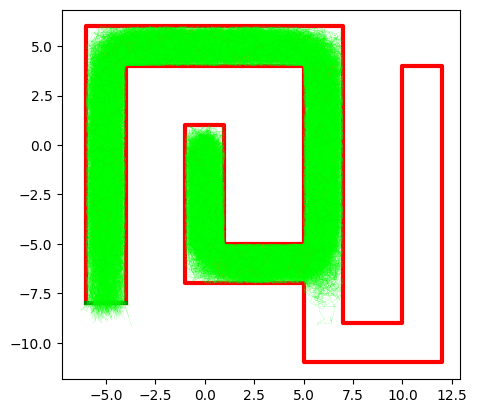

In [6]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

In [7]:
times = [(data_point['time_taken'] if data_point['time_taken'] != None else np.inf) for data_point in training_data]

np.argmin(times)

175

21.10000000000003 26


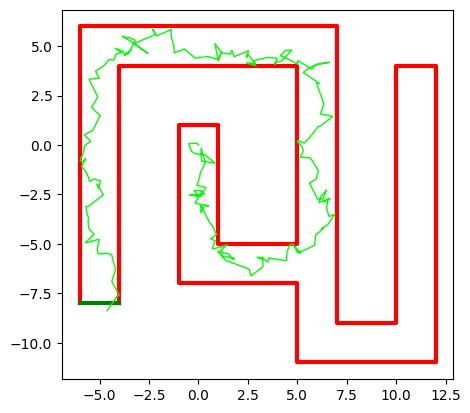

In [8]:
trial_number = 175

fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
result = training_data[trial_number]
if result['success'] == True:
    ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=1)
elif result['success'] == False:
    ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=1)

print(result['time_taken'], result['collisions'])

495


(array([  1.,   8.,  34.,  62.,  90., 108.,  77.,  61.,  34.,  20.]),
 array([21.1 , 23.94, 26.78, 29.62, 32.46, 35.3 , 38.14, 40.98, 43.82,
        46.66, 49.5 ]),
 <BarContainer object of 10 artists>)

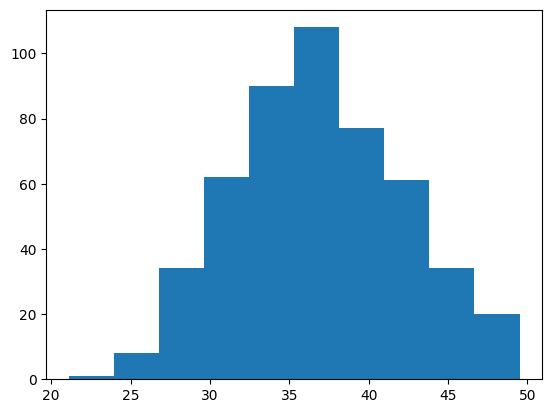

In [9]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

In [10]:
excellent_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True) and (x['time_taken'] <= 50), training_data)]
print(len(excellent_times), min(excellent_times))

495 21.10000000000003


(array([ 29.,  50., 109., 101.,  98.,  59.,  37.,  11.,   5.,   1.]),
 array([ 7. , 11.2, 15.4, 19.6, 23.8, 28. , 32.2, 36.4, 40.6, 44.8, 49. ]),
 <BarContainer object of 10 artists>)

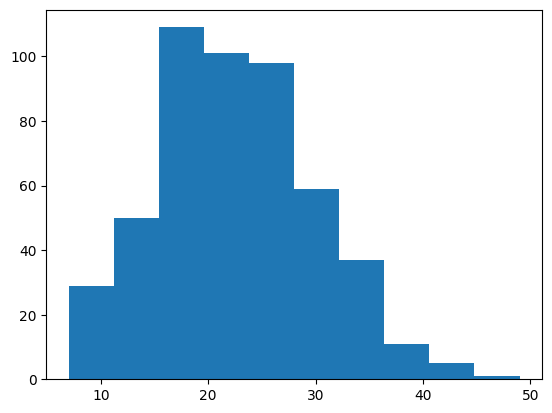

In [11]:
collisions = [data_point['collisions'] for data_point in training_data]
plt.hist(collisions)

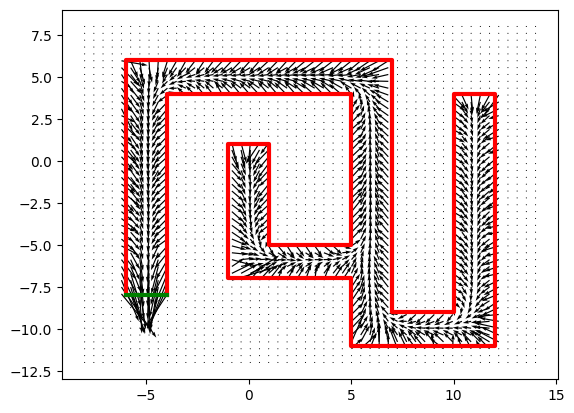

In [12]:
fig, ax = plt.subplots()

for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.quiver(x_mesh, y_mesh, np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 0], np.transpose(drift_function['drift_value'], (1, 0, 2))[:, :, 1])


We've run so many generations of this training process. But doing it each time manually and evaluating it every single time is costly. So the next step would be to automate the training process. To do that we can use the code we built so far and enclose it into a loop. We must set a goal, for example for the simulation to stop training when a particular target time is reached a certain percentage of the time with the model, or until the training process is too long, like too many iterations. All we need to do is enclose the code we've been running many times and update the parameters as appropriate. Once done, we will save the model results in a Pickle file. For everything we need, we take all the code above starting from the import statements.

But we also need to think about the data structure of how we do things. So far, this version of the model uses only training data and drift functions stored, so an idea will be to instead this time make new objects that also store metadata, like in a dictionary. Things like the date and time the drift model was created, an ID for the model, or the generation number. That ID can get referenced in training data which shall also be a metadata attribute.

Another problem is the way each iteration takes a long time to run, so to limit that, we can set a time limit for each training generation in the process, say one minute, or until the desired number of training trajectories has been reached.

The analysis section, that is the code cells that deal with analyzing and plotting test results, can be put in a separate section for future analysis after running a particular trajectory.

Let's rearrange the code to automate it. The first step shall be to put the training process into one function with variable training parameters so we can easily run a function. Let's make sure the first step is done.

Also, some of the functions have been tucked into the other modules in the folder for better organization.

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pickle
import datetime
from geom_functions import *
from brownian_motion_obstacle_course import *
from train_maze import *

In [ ]:
# Set up the experiment

obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]
x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)
time_limit = 40
timestep = 0.1
start_point = np.array([0, 0])
simulations = 100
diffusion = 1
speed_limit = 3
rolling_speed_period = 20
memory_retention = 0.8
running_period = 5
collision_penalty = 0.05

# Load the latest drift function

drift_file = 'drift_functions/gen_118_20251125_194933.pkl'

with open(drift_file, 'rb') as f:
    drift_function = pickle.load(f)
    f.close()

# Start training

results = train_next_generation(drift_function = drift_function,
                                obstacles = obstacles,
                                exits = exits,
                                x_mesh = x_mesh,
                                y_mesh = y_mesh,
                                start_point = start_point,
                                time_limit = time_limit,
                                timestep = timestep,
                                simulations = simulations,
                                print_progress = True,
                                diffusion = diffusion,
                                speed_limit = speed_limit,
                                rolling_speed_period = rolling_speed_period,
                                memory_retention = memory_retention,
                                running_period = running_period,
                                collision_penalty = collision_penalty)


training_data = results['training_data']
new_drift_function = results['new_drift_function']

# Save the training data into a Pickle file

generation = drift_function['generation']
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

filename = 'training_data/gen_{:03d}_{}.pkl'.format(generation, timestamp)

with open(filename, 'wb') as f:
    pickle.dump(training_data, f)
    f.close()

# Save the updated drift function into a Pickle file

filename = 'drift_functions/gen_{:03d}_{}.pkl'.format(generation + 1, timestamp)

with open(filename, 'wb') as f:
    pickle.dump(new_drift_function, f)
    f.close()

This version of the code seems to be running without issues. Now, does the analysis block still hold up?

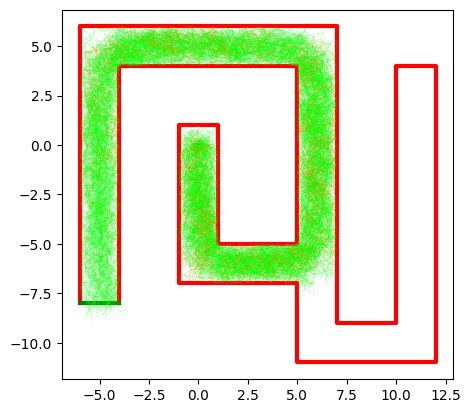

In [4]:
fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
for result in training_data:
    if result['success'] == True:
        ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=0.1)
    elif result['success'] == False:
        ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=0.1)

In [5]:
times = [(data_point['time_taken'] if data_point['time_taken'] != None else np.inf) for data_point in training_data]

np.argmin(times)

18

24.300000000000075 25


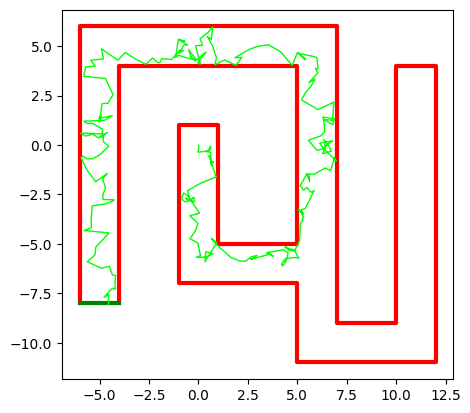

In [6]:
trial_number = 18

fig, ax = plt.subplots()
ax.set_aspect(1)
for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
result = training_data[trial_number]
if result['success'] == True:
    ax.plot(result['path'][0], result['path'][1], 'lime', linewidth=1)
elif result['success'] == False:
    ax.plot(result['path'][0], result['path'][1], 'darkorange', linewidth=1)

print(result['time_taken'], result['collisions'])

86


(array([ 4.,  3., 12., 16.,  7., 15., 12., 12.,  4.,  1.]),
 array([24.3 , 25.86, 27.42, 28.98, 30.54, 32.1 , 33.66, 35.22, 36.78,
        38.34, 39.9 ]),
 <BarContainer object of 10 artists>)

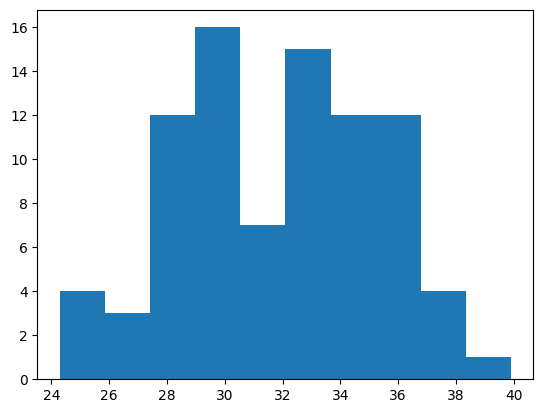

In [7]:
successful_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True), training_data)]
print(len(successful_times))
plt.hist(successful_times)

In [8]:
excellent_times = [data_point['time_taken'] for data_point in filter(lambda x: (x['success'] == True) and (x['time_taken'] <= 35), training_data)]
print(len(excellent_times), min(excellent_times))

66 24.300000000000075


(array([ 6., 14., 15., 17., 15., 17., 10.,  4.,  1.,  1.]),
 array([ 9. , 11.9, 14.8, 17.7, 20.6, 23.5, 26.4, 29.3, 32.2, 35.1, 38. ]),
 <BarContainer object of 10 artists>)

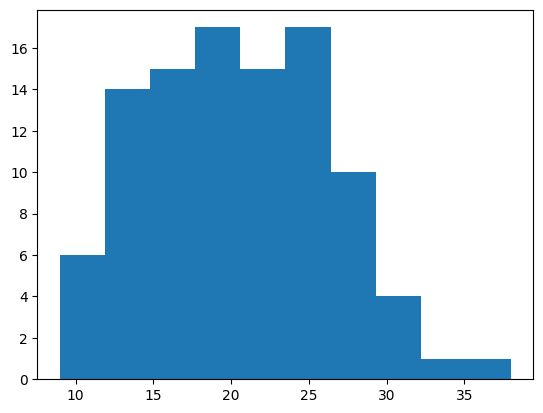

In [9]:
collisions = [data_point['collisions'] for data_point in training_data]
plt.hist(collisions)

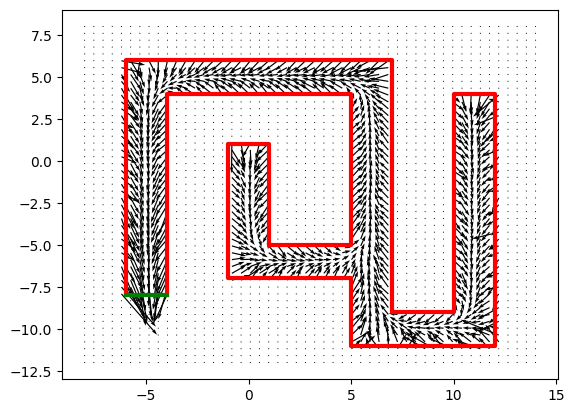

In [10]:
fig, ax = plt.subplots()

for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.quiver(x_mesh, y_mesh, np.transpose(new_drift_function['drift_value'], (1, 0, 2))[:, :, 0], np.transpose(new_drift_function['drift_value'], (1, 0, 2))[:, :, 1])


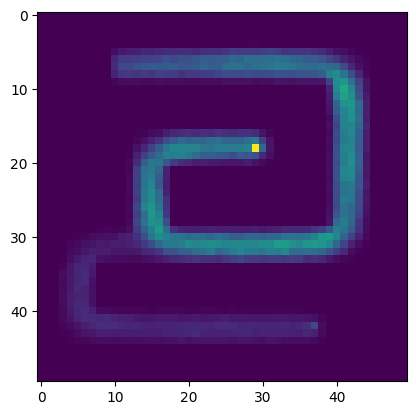

In [11]:
plt.imshow(new_drift_function['weights'])

In [14]:
new_drift_function.keys()

dict_keys(['totals', 'weights', 'drift_value', 'x_mesh', 'y_mesh', 'generation', 'timestamp', 'obstacles', 'exits'])

In [16]:
new_drift_function['weights'].shape

(50, 50)

The answer: Yes! And you may observe the data does get updated.

Now the next step is to automate how it is trained, and to build an algorithm to decide what parameters get changed based on the training data analysis. Based on what we did manually, the approximate training regimen has been to run the simulation from the beginning at base drift statistics with a very high time limit, then train the drifts based on each run, and update the time limit and other parameters based on how well it performs.

Here's a rule we might use as one of our parameter decisions for the next training: If 95% of simulations succeed within the time limit, update the time to the 70% quantile of the times recorded in the simulation. But if the success rate is 20% or less, increase the time limit by, say, 20%.

Then repeat until you reach a target time you desire at, say, a 95% success rate, or until the training takes too long to reach the target, in that case break.

We will also need to figure out a way to store and save the data for the drift policies at each generation and also the training data, so we can analyze the results for the future. That way we can see how drift policies evolve over time for any maze we construct.

# Latest version: Start here

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pickle
import datetime
from geom_functions import *
from brownian_motion_obstacle_course import *
from train_maze import *

In [3]:
# Set up the experiment

obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12, 10, 10, 7, 7, -6, -6], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4, 4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]])]
x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)
start_point = np.array([0, 0])
time_limit = 1000

In [ ]:
training_results = train_maze_simulation(obstacles = obstacles,
                                exits = exits,
                                x_mesh = x_mesh,
                                y_mesh = y_mesh,
                                start_point = start_point,
                                time_limit = time_limit,
                                steps = 100,
                                training_iterations = 100,
                                target_time = 50,
                                target_success_rate = 0.95)

Phew! We've just built a big function (and also not to mention the modules we've built that it depends on) that automatically trains a maze over several generations in an automated way (the function is now tucked into `train_maze.py` since it's too long to read). But how do the results look?

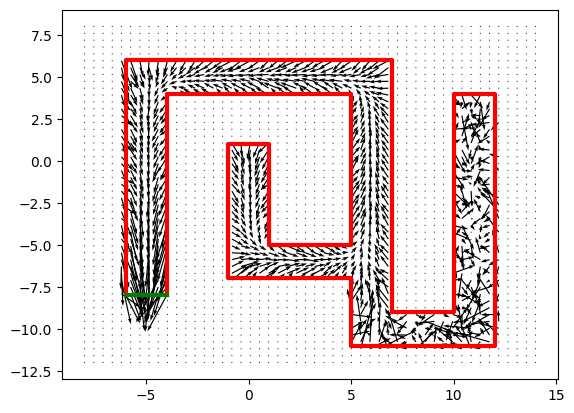

In [5]:
drift_value = training_results['drift_functions'][100]['drift_value']

fig, ax = plt.subplots()

for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.quiver(x_mesh, y_mesh, np.transpose(drift_value, (1, 0, 2))[:, :, 0], np.transpose(drift_value, (1, 0, 2))[:, :, 1])


You can see for yourself by changing the number in the index. The drift model does indeed evolve, a great result we've achieved thanks to the complex programming we gradually built up. And at that, we've accomplished a lot by producing a result that shows the training program is working. Great work! Now let's save the training data into a Pickle file.


In [6]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

filename = 'training_sample_{}.pkl'.format(timestamp)

with open(filename, 'wb') as f:
    pickle.dump(training_results, f)
    f.close()

One more thing: We've plotted a semilog graph to show how average times decrease over each generation. As this graph for this particular result set shows, the time seems to decrease exponentially with the training. A good result showing how robust the scheme is.

In [7]:
def plot_average_times(training_results):
    total_times = {}
    time_counts = {}

    for data_point in training_results['training_data']:
        if data_point['success'] == True:
            generation = data_point['generation']
            if generation not in total_times:
                total_times[generation] = 0
                time_counts[generation] = 0
            total_times[generation] += data_point['time_taken']
            time_counts[generation] += 1

    average_times = {}
    for generation in total_times:
        average_times[generation] = total_times[generation] / time_counts[generation]

    plt.semilogy(average_times.keys(), average_times.values())

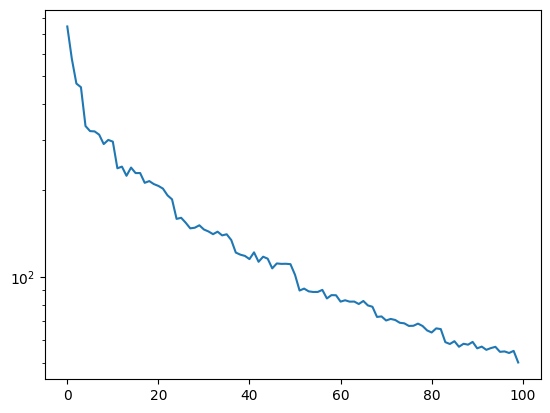

In [8]:
plot_average_times(training_results)

As you can see, there's an exponentially evolving improvement in the simulation, which tells us that it is working well.

Now, shall we try a new maze, instead of this one we've used over and over again? But first, let's save the results, using the code block above.

One more thing to add is a function to plot a maze, to make it easy to visualize the map before we even start training on it.

In [50]:
def draw_maze(obstacles, exits):
    fig, ax = plt.subplots()
    ax.set_aspect(1)
    for obstacle in obstacles:
        ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
    for exit in exits:
        ax.plot(exit[0], exit[1], 'g', linewidth=3)
    plt.show()

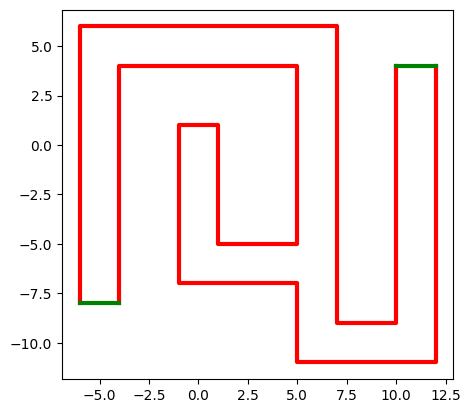

In [ ]:
obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4]]),
             np.array([[10, 10, 7, 7, -6, -6], [4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]]), np.array([[12, 10], [4, 4]])]

draw_maze(obstacles, exits)

Let's try it again with this time a new exit opens on the other side of the maze, so we can explore how branching happens.

In [3]:
obstacles = [np.array([[-4, -4, 5, 5, 1, 1, -1, -1, 5, 5, 12, 12], [-8, 4, 4, -5, -5, 1, 1, -7, -7, -11, -11, 4]]),
             np.array([[10, 10, 7, 7, -6, -6], [4, -9, -9, 6, 6, -8]])]
exits = [np.array([[-4, -6], [-8, -8]]), np.array([[12, 10], [4, 4]])]
x_mesh = np.linspace(-8, 14)
y_mesh = np.linspace(-12, 8)
start_point = np.array([0, 0])
time_limit = 1000

In [ ]:
training_results = train_maze_simulation(obstacles = obstacles,
                                exits = exits,
                                x_mesh = x_mesh,
                                y_mesh = y_mesh,
                                start_point = start_point,
                                time_limit = time_limit,
                                steps = 100,
                                training_iterations = 100,
                                target_time = 70,
                                target_success_rate = 0.90)

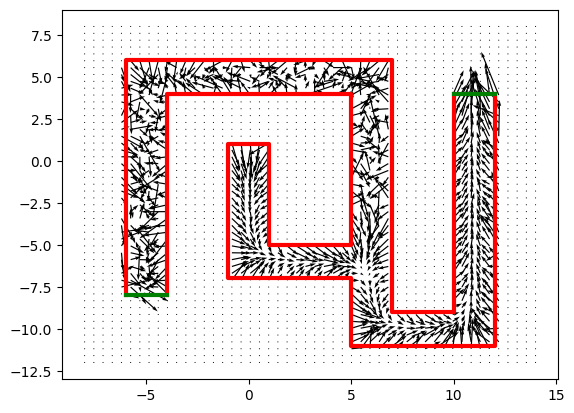

In [10]:
drift_value = training_results['drift_functions'][51]['drift_value']

fig, ax = plt.subplots()

for obstacle in obstacles:
    ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
for exit in exits:
    ax.plot(exit[0], exit[1], 'g', linewidth=3)
ax.quiver(x_mesh, y_mesh, np.transpose(drift_value, (1, 0, 2))[:, :, 0], np.transpose(drift_value, (1, 0, 2))[:, :, 1])


In [11]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

filename = 'training_sample_{}.pkl'.format(timestamp)

with open(filename, 'wb') as f:
    pickle.dump(training_results, f)
    f.close()

In [52]:
with open('training_sample_20251126_012113.pkl', 'rb') as f:
    training_results = pickle.load(f)
    f.close()

In [23]:
def plot_average_times(training_results):
    total_times = {}
    time_counts = {}

    for data_point in training_results['training_data']:
        if data_point['success'] == True:
            generation = data_point['generation']
            if generation not in total_times:
                total_times[generation] = 0
                time_counts[generation] = 0
            total_times[generation] += data_point['time_taken']
            time_counts[generation] += 1

    average_times = {}
    for generation in total_times:
        average_times[generation] = total_times[generation] / time_counts[generation]

    plt.semilogy(average_times.keys(), average_times.values())

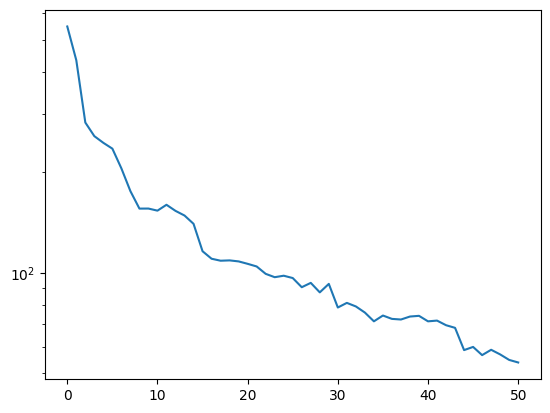

In [53]:
plot_average_times(training_results)

Now, let's try another new maze. This time we shall make one that consists of three diamonds.

In [55]:
obstacles = [np.array([[1.5, 0, -2, 0, 1.5], [0.5, 2, 0, -2, -0.5]]),
             np.array([[-3, 0, 4, 0, -3], [1, 4, 0, -4, -1]]),
             np.array([[7, 0, -8, 0, 7], [1, 8, 0, -8, -1]])]
exits = [np.array([[7, 7], [1, -1]])]
x_mesh = np.linspace(-10, 10)
y_mesh = np.linspace(-10, 10)
start_point = np.array([0, 0])
time_limit = 1000

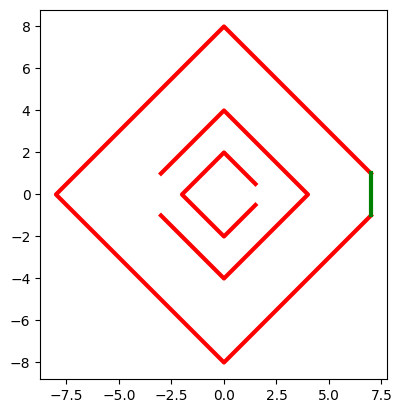

In [56]:
draw_maze(obstacles, exits)

In [ ]:
training_results = train_maze_simulation(obstacles = obstacles,
                                exits = exits,
                                x_mesh = x_mesh,
                                y_mesh = y_mesh,
                                start_point = start_point,
                                time_limit = time_limit,
                                steps = 100,
                                training_iterations = 100,
                                target_time = 100,
                                target_success_rate = 0.90)

In [58]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

filename = 'training_sample_{}.pkl'.format(timestamp)

with open(filename, 'wb') as f:
    pickle.dump(training_results, f)
    f.close()

In [60]:
def plot_drift_field(drift_function):
    drift_value = drift_function['drift_value']
    obstacles = drift_function['obstacles']
    exits = drift_function['exits']
    x_mesh = drift_function['x_mesh']
    y_mesh = drift_function['y_mesh']

    fig, ax = plt.subplots()

    fig.suptitle('Drift Field For Generation {}'.format(drift_function['generation']))

    ax.set_aspect(1)
    for obstacle in obstacles:
        ax.plot(obstacle[0], obstacle[1], 'r', linewidth=3)
    for exit in exits:
        ax.plot(exit[0], exit[1], 'g', linewidth=3)
    ax.quiver(x_mesh, y_mesh, np.transpose(drift_value, (1, 0, 2))[:, :, 0], np.transpose(drift_value, (1, 0, 2))[:, :, 1])
    plt.show()

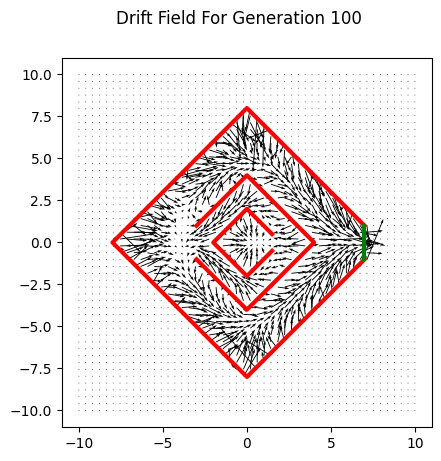

In [64]:
plot_drift_field(training_results['drift_functions'][-1])

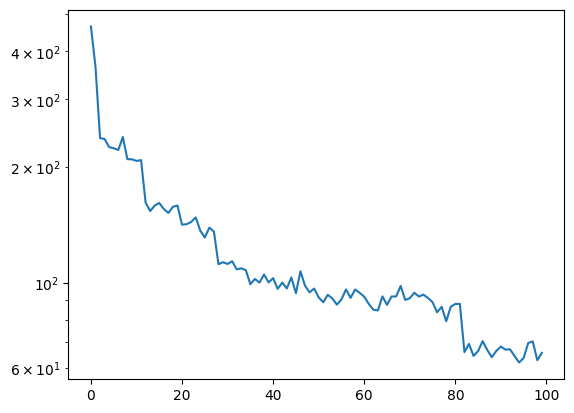

In [66]:
plot_average_times(training_results)

As of the current version, I've updated my mathematical functions module to support some new functionality by adapting what's existing into a new function that calculates bounces. There's plenty of mathematical theory used in the bounce function, which I've written to calculate the overall trajectory given a start and end point within an obstacle course including bounces off the obstacles. This way, we write a new way to handle collisions in the way that a new version of the simulation supports bouncing and can count all collisions.